# Fake News Detection - Spanish

In [1]:
# Import libraries

# Main
import sys
sys.path.insert(0,'../')
import os
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

# NLP
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

# Transformers
from transformers import AutoTokenizer, AutoModel, TFAutoModel

# Sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# Display
from IPython.display import clear_output
clear_output()

### Loading data

In [2]:
from utils import Utils
utils = Utils('/media/juan/Juan/NLP/', num_workers=10)

In [3]:
# Define language
lang = 'es'

print('Starting...')

news_data, _, _ = utils.data_loader(lang, 'news', total_data=20000, max_size = None, return_dates = False)
fake_news_data, _, _ = utils.data_loader(lang, 'FakeNews', total_data=13408, max_size = None, return_dates = False)

print(f'Loaded {len(news_data)} news {len(fake_news_data)} fake news')

data = news_data + fake_news_data
tags = [1]*len(news_data) + [0]*len(fake_news_data)

Starting...
Starting 10 threads to load 20000 documents from news in es
Loaded 20000 files in 441.53 seconds.
Removed 0 files becasuse they were too large
Starting 10 threads to load 13408 documents from FakeNews in es
Loaded 13408 files in 17.37 seconds.
Removed 0 files becasuse they were too large
Loaded 20000 news 13408 fake news


### Glimpse at data

In [4]:
news_num = 5
print(news_data[news_num])
print('------------------------------------------------------------------------------')
print(fake_news_data[news_num])

CVS Health ahora está aceptando personas sin cita previa, para la vacuna contra el  COVID-19 en todas sus 8,300 ubicaciones de CVS Pharmacy en todo el condado, anunció la compañía el miércoles.Esto incluye 800 ubicaciones en Texas.No es necesaria una cita, la programación para el mismo día también está disponible en CVS.com, dijo la compañía en un comunicado de prensa.CVS Health ha superado las 17 millones de dosis de la vacuna COVID-19 administradas en sus farmacias, según el comunicado de prensa.Si desea programar una cita puede hacerlo visitando la página cvs.comel programa de vacunas contra el covid-19 se actualizará durante el día para responder  cancelaciones  el mismo.Vea el video para el reportaje completo.
------------------------------------------------------------------------------
Sanidad registra 7.586 nuevos casos de Covid-19, 590 muertes y la incidencia sigue subiendo - www.infosalus.com. 
Según el grupo de investigación de la Fundación para la Prevención y la Tolandanci

### Feature extraction using BERT

In [5]:
# Stop Words
stop_words = stopwords.words('spanish')
# Stemmers
stem = SnowballStemmer('spanish')
#p_stem = PorterStemmer()
# Tokenizers
#tk = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
tk = nltk.RegexpTokenizer(r'\w+')
# Lemmatizer
lemma = nltk.stem.WordNetLemmatizer()
# Preprocess data
corpus = []
for d in tqdm(data):
    corpus.append(utils.preprocessing(d, stop_words = stop_words,
                                         stemmer = None,
                                         tokenizer = tk,
                                         lemmatizer = lemma))

100%|██████████| 33408/33408 [02:34<00:00, 216.79it/s]


####  Reduce data size

In [6]:
for i in range(len(corpus)):
    corpus[i] = corpus[i][:500]

#### Load model

In [7]:
# Bert instance EN (COVID)
model_name = "mrm8488/bert-mini-finetuned-age_news-classification"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModel.from_pretrained(model_name, output_hidden_states=False)
device = torch.device("cuda")
model.to(device)

# Bert instance FR
# tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-french-europeana-cased")
# model = AutoModel.from_pretrained("dbmdz/bert-base-french-europeana-cased", output_hidden_states=True)

# Bert instance ES (BETICO)
# tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
# model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", output_hidden_states=False)

# tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-ag-news", device=0)
# model = AutoModel.from_pretrained("textattack/bert-base-uncased-ag-news", output_hidden_states=False)

clear_output()

#### Obtain first doc's embedding

In [8]:
# Test Model for first sentence
inputs = tokenizer(corpus[0], return_tensors="pt", is_split_into_words=True)
inputs.to(device)
outputs = model(**inputs)

# Just pooler output as embeddings
embedding = outputs['pooler_output'].detach().cpu().numpy()
print(embedding.shape)

(1, 256)


#### Tokenize each doch in corpus

In [9]:
# Array to save embeddings
reu_embeddings = []

failed_doc_ids = []

for i, doc in enumerate(tqdm(corpus)):
    try:
        # Run Bert for each document
        inputs = tokenizer(doc, return_tensors="pt", is_split_into_words=True)
        inputs.to(device)
        outputs = model(**inputs)

        # CLS Token Output
        embedding = outputs['pooler_output'].detach().cpu().numpy()[0]

        # Append representation
        reu_embeddings.append(embedding)
        
    except:
        failed_doc_ids.append(i)
    
print(f'Failed to tokenize {len(failed_doc_ids)} documents')

100%|██████████| 33408/33408 [03:47<00:00, 146.67it/s]

Failed to tokenize 0 documents


#### Remove failed documents and corresponding tags

In [10]:
# Remove failed docs
for i, doc_id in enumerate(failed_doc_ids):
    corpus.pop(doc_id - i)
    tags.pop(doc_id - i)

#### Split data and train MLP classifier

In [11]:
model_dict = {'NB': GaussianNB(), 
              'LR': LogisticRegression(random_state=0, max_iter = 1500), 
              'MLP': MLPClassifier(hidden_layer_sizes=(100), random_state=1, max_iter=1500),
              'SVM': svm.SVC()}

In [12]:
def test_sklearn_models(model, metrics_df, X, y, vectorizer_type, val_percentage = 0.2):
    """ Train and evaluate model with specified arguments
    
    Args:
        model (str): Model to train
        metrics_df (pd.DataFrame): Dataframe to save the results
        X (np.ndarray): Features of data
        y (list): Tags of X
        vectorizer_type (str): Vectorizer used to extract features
        val_percentage (float): Validation percentage
    
    Returns:
        pd.DataFrame: Results of trained and evaluated model
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 1 - val_percentage)
    clf = model_dict[model]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    pre = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    data = {'model': [model], 'features': [vectorizer_type], 'lang': [lang], 'accuracy': [acc], 'precision': [pre], 'recall': [rec], 'f1': [f1]}
    df = metrics_df.append([pd.DataFrame(data = data)])
    return df

In [13]:
X = reu_embeddings
y = tags
MODEL_TPYE_ = ['NB', 'LR', 'MLP', 'SVM']
# metrics = pd.DataFrame()
metrics = pd.read_csv('./../../results/FakeNewsDetection/fake_news_detection_results.csv',index_col=0)
for model_type in MODEL_TPYE_:
    tokenizer='BERT'
    metrics = test_sklearn_models(model_type, metrics, X, y, tokenizer)
    print(f'Training {model_type} with {tokenizer} feature extraction')

Training NB with BERT feature extraction
Training LR with BERT feature extraction
Training MLP with BERT feature extraction
Training SVM with BERT feature extraction


In [14]:
from tensorflow import keras
from tensorflow.keras import layers
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 1 - 0.8)
with tf.device('/GPU:0'):
    model = keras.Sequential([
            layers.Dense(100, activation="relu", input_shape=(len(X_train), 256)),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
            ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    history = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), epochs=1500, verbose=0)
clear_output()

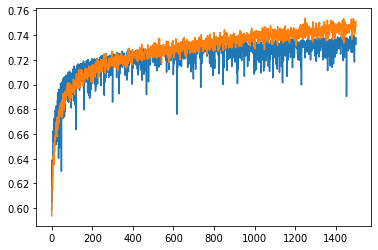

In [15]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

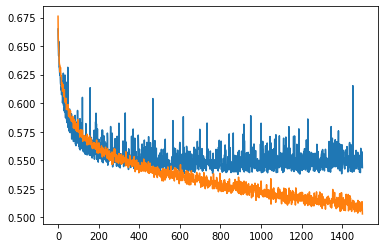

In [16]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

In [17]:
metrics.to_csv('./../../results/FakeNewsDetection/fake_news_detection_results.csv')